In [341]:
using CSV, DataFrames, Statistics, Dates, Gadfly, GLM, Distributions, LinearAlgebra, ScikitLearn, Query
include("Utils.jl")

categorizeMax (generic function with 1 method)

## Collecte et nettoyage de donnees

In [342]:
data_surverse = CSV.read("data/surverses.csv",missingstring="-99999")
first(data_surverse,5)

5×4 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │ RAISON  │
│     │ String     │ Date       │ Int64⍰   │ String⍰ │
├─────┼────────────┼────────────┼──────────┼─────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │ missing │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │ missing │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │ missing │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │ missing │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │ missing │

In [343]:
data_surverse = filter(row -> month(row.DATE) > 4, data_surverse) 
data_surverse = filter(row -> month(row.DATE) < 11, data_surverse) 
first(data_surverse,5)

5×4 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │ RAISON  │
│     │ String     │ Date       │ Int64⍰   │ String⍰ │
├─────┼────────────┼────────────┼──────────┼─────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │ missing │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │ missing │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │ missing │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │ missing │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │ missing │

In [344]:
raison = coalesce.(data_surverse[:,:RAISON],"Inconnue")
data_surverse[!,:RAISON] = raison
first(data_surverse,5)

5×4 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │ RAISON   │
│     │ String     │ Date       │ Int64⍰   │ String   │
├─────┼────────────┼────────────┼──────────┼──────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │ Inconnue │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │ Inconnue │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │ Inconnue │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │ Inconnue │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │ Inconnue │

In [345]:
data_surverse = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data_surverse) 
select!(data_surverse, [:NO_OUVRAGE, :DATE, :SURVERSE])
first(data_surverse,5)

5×3 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │
│     │ String     │ Date       │ Int64⍰   │
├─────┼────────────┼────────────┼──────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │

In [346]:
surverse_df = dropmissing(data_surverse, disallowmissing=true)
first(surverse_df,5)

5×3 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │
│     │ String     │ Date       │ Int64    │
├─────┼────────────┼────────────┼──────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │

In [347]:
data_precipitations = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data_precipitations, Symbol("St-Hubert")=>:StHubert)
first(data_precipitations,5)

5×7 DataFrame. Omitted printing of 1 columns
│ Row │ date       │ heure │ McTavish │ Bellevue │ Assomption │ Trudeau │
│     │ Date       │ Int64 │ Int64⍰   │ Int64⍰   │ Int64⍰     │ Int64⍰  │
├─────┼────────────┼───────┼──────────┼──────────┼────────────┼─────────┤
│ 1   │ 2013-01-01 │ 0     │ 0        │ 0        │ 0          │ 0       │
│ 2   │ 2013-01-01 │ 1     │ 0        │ 0        │ 0          │ 0       │
│ 3   │ 2013-01-01 │ 2     │ 0        │ 0        │ 0          │ 0       │
│ 4   │ 2013-01-01 │ 3     │ 0        │ 0        │ 0          │ 0       │
│ 5   │ 2013-01-01 │ 4     │ 0        │ 0        │ 0          │ 0       │

In [348]:
data_precipitations = filter(row -> month(row.date) > 4, data_precipitations) 
data_precipitations = filter(row -> month(row.date) < 11, data_precipitations)
rowMean(data_precipitations, 5, 2)
first(data_precipitations,5)

5×7 DataFrame. Omitted printing of 1 columns
│ Row │ date       │ heure │ McTavish │ Bellevue │ Assomption │ Trudeau │
│     │ Date       │ Int64 │ Int64⍰   │ Int64⍰   │ Int64⍰     │ Int64⍰  │
├─────┼────────────┼───────┼──────────┼──────────┼────────────┼─────────┤
│ 1   │ 2013-05-01 │ 0     │ 0        │ 0        │ 0          │ 0       │
│ 2   │ 2013-05-01 │ 1     │ 0        │ 0        │ 0          │ 0       │
│ 3   │ 2013-05-01 │ 2     │ 0        │ 0        │ 0          │ 0       │
│ 4   │ 2013-05-01 │ 3     │ 0        │ 0        │ 0          │ 0       │
│ 5   │ 2013-05-01 │ 4     │ 0        │ 0        │ 0          │ 0       │

## Variable explicative 1 : Trop-Plein Z

In [349]:
data_ouvrage = CSV.read("data/ouvrages-surverses.csv",missingstring="")

# Extract speficic ouvrage
df_ouvrage = filter(row ->
    row.ID_ouvrage == "3260-01D" ||
    row.ID_ouvrage == "3350-07D" ||
    row.ID_ouvrage == "4240-01D" ||
    row.ID_ouvrage == "4350-01D" ||
    row.ID_ouvrage == "4380-01D", data_ouvrage)

df_ouvrage = df_ouvrage[:,[:ID_ouvrage, Symbol("Trop-Plein Z")]]
rename!(df_ouvrage, Symbol("ID_ouvrage")=>:NO_OUVRAGE)

meanHeight = mean(skipmissing(df_ouvrage[Symbol("Trop-Plein Z")]))

# Replace missing height with it's mean
df_ouvrage[ismissing.(df_ouvrage[Symbol("Trop-Plein Z")]), Symbol("Trop-Plein Z")] .= meanHeight

df_ouvrage

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[349]:13
└ @ Core In[349]:13
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[349]:15
└ @ Core In[349]:15


5×2 DataFrame
│ Row │ NO_OUVRAGE │ Trop-Plein Z │
│     │ String     │ Float64⍰     │
├─────┼────────────┼──────────────┤
│ 1   │ 3260-01D   │ 20.17        │
│ 2   │ 3350-07D   │ 20.75        │
│ 3   │ 4240-01D   │ 11.91        │
│ 4   │ 4350-01D   │ 17.61        │
│ 5   │ 4380-01D   │ 17.61        │

## Variable explicative 2 : Somme des précipitations par jour

In [350]:
# Faire la somme des precipitations par rapport a la date
pcp_sum = by(data_precipitations, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
           Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)

first(pcp_sum,5)


5×6 DataFrame
│ Row │ date       │ McTavish │ Bellevue │ Assomption │ Trudeau │ StHubert │
│     │ Date       │ Int64    │ Int64    │ Int64      │ Int64   │ Int64    │
├─────┼────────────┼──────────┼──────────┼────────────┼─────────┼──────────┤
│ 1   │ 2013-05-01 │ 0        │ 0        │ 0          │ 0       │ 0        │
│ 2   │ 2013-05-02 │ 0        │ 0        │ 0          │ 0       │ 0        │
│ 3   │ 2013-05-03 │ 0        │ 0        │ 0          │ 0       │ 0        │
│ 4   │ 2013-05-04 │ 0        │ 0        │ 0          │ 0       │ 0        │
│ 5   │ 2013-05-05 │ 0        │ 0        │ 0          │ 0       │ 0        │

## Variable explicative 3 : Maximum horaire de précipitation par jour

In [351]:
# Trouver le max de precipitation journalier
pcp_max = by(data_precipitations, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)

rename!(pcp_max,
    Symbol("McTavish")=>:McTavishMax,
    Symbol("Bellevue")=>:BellevueMax,
    Symbol("Assomption")=>:AssomptionMax,
    Symbol("Trudeau")=>:TrudeauMax,
    Symbol("StHubert")=>:StHubertMax)


1288×6 DataFrame. Omitted printing of 1 columns
│ Row  │ date       │ McTavishMax │ BellevueMax │ AssomptionMax │ TrudeauMax │
│      │ Date       │ Int64       │ Int64       │ Int64         │ Int64      │
├──────┼────────────┼─────────────┼─────────────┼───────────────┼────────────┤
│ 1    │ 2013-05-01 │ 0           │ 0           │ 0             │ 0          │
│ 2    │ 2013-05-02 │ 0           │ 0           │ 0             │ 0          │
│ 3    │ 2013-05-03 │ 0           │ 0           │ 0             │ 0          │
│ 4    │ 2013-05-04 │ 0           │ 0           │ 0             │ 0          │
│ 5    │ 2013-05-05 │ 0           │ 0           │ 0             │ 0          │
│ 6    │ 2013-05-06 │ 0           │ 0           │ 0             │ 0          │
│ 7    │ 2013-05-07 │ 0           │ 0           │ 0             │ 0          │
│ 8    │ 2013-05-08 │ 0           │ 0           │ 0             │ 0          │
│ 9    │ 2013-05-09 │ 10          │ 0           │ 19            │ 0          │
│ 10   │ 2013-05-10 │ 0           │ 4           │ 20            │ 0          │
⋮
│ 1278 │ 2019-10-21 │ 0           │ 0           │ 0             │ 0          │
│ 1279 │ 2019-10-22 │ 31          │ 22          │ 22            │ 53         │
│ 1280 │ 2019-10-23 │ 58          │ 29          │ 29            │ 28         │
│ 1281 │ 2019-10-24 │ 0           │ 0           │ 0             │ 0          │
│ 1282 │ 2019-10-25 │ 0           │ 0           │ 0             │ 0          │
│ 1283 │ 2019-10-26 │ 0           │ 0           │ 0             │ 0          │
│ 1284 │ 2019-10-27 │ 102         │ 56          │ 56            │ 98         │
│ 1285 │ 2019-10-28 │ 3           │ 1           │ 1             │ 2          │
│ 1286 │ 2019-10-29 │ 0           │ 0           │ 0             │ 0          │
│ 1287 │ 2019-10-30 │ 0           │ 0           │ 0             │ 0          │
│ 1288 │ 2019-10-31 │ 0           │ 0           │ 0             │ 0          │

## Préparation pour créer le modèle

In [352]:
# Filtrer les ouvrages étudiés
df_surve = filter(row ->
    row.NO_OUVRAGE == "3260-01D" ||
    row.NO_OUVRAGE == "3350-07D" ||
    row.NO_OUVRAGE == "4240-01D" ||
    row.NO_OUVRAGE == "4350-01D" ||
    row.NO_OUVRAGE == "4380-01D", surverse_df)

rename!(df_surve, Symbol("DATE")=>:date)

# # Fusionner les datasets contenant les ouvrages etudies et les variables explicatives ensemble
enhanced_surve = join(df_surve, pcp_sum, on=:date, kind=:inner)
enhanced_surve = join(enhanced_surve, pcp_max, on=:date, kind=:inner)
enhanced_surve = join(enhanced_surve, df_ouvrage, on=:NO_OUVRAGE, kind=:left)

5129×14 DataFrame. Omitted printing of 8 columns
│ Row  │ NO_OUVRAGE │ date       │ SURVERSE │ McTavish │ Bellevue │ Assomption │
│      │ String     │ Date       │ Int64    │ Int64    │ Int64    │ Int64      │
├──────┼────────────┼────────────┼──────────┼──────────┼──────────┼────────────┤
│ 1    │ 3260-01D   │ 2013-05-01 │ 0        │ 0        │ 0        │ 0          │
│ 2    │ 3260-01D   │ 2013-05-02 │ 0        │ 0        │ 0        │ 0          │
│ 3    │ 3260-01D   │ 2013-05-03 │ 0        │ 0        │ 0        │ 0          │
│ 4    │ 3260-01D   │ 2013-05-04 │ 0        │ 0        │ 0        │ 0          │
│ 5    │ 3260-01D   │ 2013-05-05 │ 0        │ 0        │ 0        │ 0          │
│ 6    │ 3260-01D   │ 2013-05-06 │ 0        │ 0        │ 0        │ 0          │
│ 7    │ 3260-01D   │ 2013-05-07 │ 0        │ 0        │ 0        │ 0          │
│ 8    │ 3260-01D   │ 2013-05-08 │ 0        │ 0        │ 0        │ 0          │
│ 9    │ 3260-01D   │ 2013-05-09 │ 0        │ 10       │ 0        │ 19         │
│ 10   │ 3260-01D   │ 2013-05-10 │ 0        │ 0        │ 4        │ 20         │
⋮
│ 5119 │ 4380-01D   │ 2018-10-21 │ 0        │ 0        │ 0        │ 0          │
│ 5120 │ 4380-01D   │ 2018-10-22 │ 0        │ 0        │ 0        │ 0          │
│ 5121 │ 4380-01D   │ 2018-10-23 │ 0        │ 0        │ 0        │ 0          │
│ 5122 │ 4380-01D   │ 2018-10-24 │ 0        │ 18       │ 3        │ 12         │
│ 5123 │ 4380-01D   │ 2018-10-25 │ 0        │ 0        │ 0        │ 0          │
│ 5124 │ 4380-01D   │ 2018-10-26 │ 0        │ 0        │ 0        │ 0          │
│ 5125 │ 4380-01D   │ 2018-10-27 │ 0        │ 101      │ 66       │ 71         │
│ 5126 │ 4380-01D   │ 2018-10-28 │ 0        │ 88       │ 75       │ 95         │
│ 5127 │ 4380-01D   │ 2018-10-29 │ 0        │ 13       │ 14       │ 20         │
│ 5128 │ 4380-01D   │ 2018-10-30 │ 0        │ 0        │ 0        │ 0          │
│ 5129 │ 4380-01D   │ 2018-10-31 │ 0        │ 85       │ 95       │ 78         │

In [353]:
enhanced_surve.NO_OUVRAGE[enhanced_surve.NO_OUVRAGE .== "3260-01D"] .= "1"
enhanced_surve.NO_OUVRAGE[enhanced_surve.NO_OUVRAGE .== "3350-07D"] .= "2"
enhanced_surve.NO_OUVRAGE[enhanced_surve.NO_OUVRAGE .== "4240-01D"] .= "3"
enhanced_surve.NO_OUVRAGE[enhanced_surve.NO_OUVRAGE .== "4350-01D"] .= "4"
enhanced_surve.NO_OUVRAGE[enhanced_surve.NO_OUVRAGE .== "4380-01D"] .= "5"

enhanced_surve[:NO_OUVRAGE] = [parse(Int,x) for x in enhanced_surve[:NO_OUVRAGE]] 

names(enhanced_surve)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[353]:6
└ @ Core In[353]:6
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[353]:6
└ @ Core In[353]:6


14-element Array{Symbol,1}:
 :NO_OUVRAGE           
 :date                 
 :SURVERSE             
 :McTavish             
 :Bellevue             
 :Assomption           
 :Trudeau              
 :StHubert             
 :McTavishMax          
 :BellevueMax          
 :AssomptionMax        
 :TrudeauMax           
 :StHubertMax          
 Symbol("Trop-Plein Z")

## Séparer les sommes et max en catégorie


| Indice | Somme de precipitation journaliere |
| --- | --- |
| 1 | 0 |
| 2 | ]0, 50\[ |
| 3 | \[50, 100[ |
| 4 | \[100, 150[ |
| 5 | \[150, 200[ |
| 6 | \[200, 250[ |
| 7 | \[250, 300[ |
| 8 | \[300, 350[ |
| 9 | \[350, 400[ |
| 10 | \[400, 450[ |
| 11 | \[450, 500[ |
| 12 | >= 500 |

| Indice | Max horaire journalier de precipitation |
| --- | --- |
| 1 | 0 |
| 2 | ]0, 25\[ |
| 3 | \[25, 50[ |
| 4 | \[50, 75[ |
| 5 | \[75, 100[ |
| 6 | \[100, 125[ |
| 7 | \[125, 150[ |
| 8 | \[150, 175[ |
| 9 | \[175, 200[ |
| 10 | >= 200 |

In [354]:
sumMcTavish = plot(enhanced_surve, x=:SURVERSE, y=:McTavish, Geom.boxplot)
maxMcTavish = plot(enhanced_surve, x=:SURVERSE, y=:McTavishMax, Geom.boxplot)
sumBellevue = plot(enhanced_surve, x=:SURVERSE, y=:Bellevue, Geom.boxplot)
maxBellevue = plot(enhanced_surve, x=:SURVERSE, y=:BellevueMax, Geom.boxplot)
sumAssomption = plot(enhanced_surve, x=:SURVERSE, y=:Assomption, Geom.boxplot)
maxAssomption = plot(enhanced_surve, x=:SURVERSE, y=:AssomptionMax, Geom.boxplot)
sumTrudeau = plot(enhanced_surve, x=:SURVERSE, y=:Trudeau, Geom.boxplot)
maxTrudeau = plot(enhanced_surve, x=:SURVERSE, y=:TrudeauMax, Geom.boxplot)
sumStHubert = plot(enhanced_surve, x=:SURVERSE, y=:StHubert, Geom.boxplot)
maxStHubert = plot(enhanced_surve, x=:SURVERSE, y=:StHubertMax, Geom.boxplot);

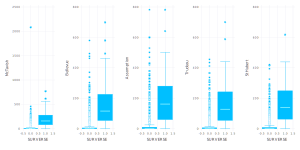

In [355]:
draw(SVGJS(30cm, 15cm), hstack([sumMcTavish, sumBellevue, sumAssomption, sumTrudeau, sumStHubert]))

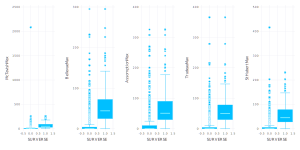

In [356]:
draw(SVGJS(30cm, 15cm), hstack([maxMcTavish, maxBellevue, maxAssomption, maxTrudeau, maxStHubert]))

In [357]:
enhanced_surve[:McTavish] = [categorizeSum(x) for x in enhanced_surve[:McTavish]]
enhanced_surve[:Bellevue] = [categorizeSum(x) for x in enhanced_surve[:Bellevue]] 
enhanced_surve[:Assomption] = [categorizeSum(x) for x in enhanced_surve[:Assomption]] 
enhanced_surve[:Trudeau] = [categorizeSum(x) for x in enhanced_surve[:Trudeau]] 
enhanced_surve[:StHubert] = [categorizeSum(x) for x in enhanced_surve[:StHubert]] 

enhanced_surve[:McTavishMax] = [categorizeMax(x) for x in enhanced_surve[:McTavishMax]]
enhanced_surve[:BellevueMax] = [categorizeMax(x) for x in enhanced_surve[:BellevueMax]] 
enhanced_surve[:AssomptionMax] = [categorizeMax(x) for x in enhanced_surve[:AssomptionMax]] 
enhanced_surve[:TrudeauMax] = [categorizeMax(x) for x in enhanced_surve[:TrudeauMax]] 
enhanced_surve[:StHubertMax] = [categorizeMax(x) for x in enhanced_surve[:StHubertMax]] 

last(enhanced_surve, 10)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[357]:1
└ @ Core In[357]:1
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[357]:1
└ @ Core In[357]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[357]:2
└ @ Core In[357]:2
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[357]:2
└ @ Core In[357]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[357]:3
└ @ Core In[357]:3
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIn

10×14 DataFrame. Omitted printing of 8 columns
│ Row │ NO_OUVRAGE │ date       │ SURVERSE │ McTavish │ Bellevue │ Assomption │
│     │ Int64      │ Date       │ Int64    │ Int64    │ Int64    │ Int64      │
├─────┼────────────┼────────────┼──────────┼──────────┼──────────┼────────────┤
│ 1   │ 5          │ 2018-10-22 │ 0        │ 1        │ 1        │ 1          │
│ 2   │ 5          │ 2018-10-23 │ 0        │ 1        │ 1        │ 1          │
│ 3   │ 5          │ 2018-10-24 │ 0        │ 2        │ 2        │ 2          │
│ 4   │ 5          │ 2018-10-25 │ 0        │ 1        │ 1        │ 1          │
│ 5   │ 5          │ 2018-10-26 │ 0        │ 1        │ 1        │ 1          │
│ 6   │ 5          │ 2018-10-27 │ 0        │ 4        │ 3        │ 3          │
│ 7   │ 5          │ 2018-10-28 │ 0        │ 3        │ 3        │ 3          │
│ 8   │ 5          │ 2018-10-29 │ 0        │ 2        │ 2        │ 2          │
│ 9   │ 5          │ 2018-10-30 │ 0        │ 1        │ 1        │ 1          │
│ 10  │ 5          │ 2018-10-31 │ 0        │ 3        │ 3        │ 3          │

## Générer le modèle

In [358]:
x = convert(Array, enhanced_surve[:,[1,4,5,6,7,8,9,10,11,12,13,14]])
y = convert(Array, enhanced_surve[:,:SURVERSE])

# Créer le modèle
@sk_import naive_bayes : MultinomialNB
nb_model = MultinomialNB()

# Entraîner le modèle
nb_model.fit(x,y)

# Evaluer l'accuracy du modèle
predictions = nb_model.predict(x)
@sk_import metrics : accuracy_score
accuracy = accuracy_score(predictions, y)
println("L'accuracy est de $accuracy")

using ScikitLearn.CrossValidation: cross_val_score
cross_val_score(MultinomialNB(), x,y, cv=5)

L'accuracy est de 0.906999415090661


┌ Warning: `convert(::Type{Array}, df::AbstractDataFrame)` is deprecated, use `convert(Matrix, df)` instead.
│   caller = top-level scope at In[358]:1
└ @ Core In[358]:1


5-element Array{Float64,1}:
 0.878286270691334 
 0.9016553067185978
 0.9317073170731708
 0.9024390243902439
 0.9121951219512195

In [359]:
### Retrieve test data
test = CSV.read("data/test.csv");

# Filtrer les ouvrages étudiés
test_df_surve = filter(row ->
    row.NO_OUVRAGE == "3260-01D" ||
    row.NO_OUVRAGE == "3350-07D" ||
    row.NO_OUVRAGE == "4240-01D" ||
    row.NO_OUVRAGE == "4350-01D" ||
    row.NO_OUVRAGE == "4380-01D", test)

rename!(test_df_surve, Symbol("DATE")=>:date)

# Fusionner les datasets contenant les ouvrages etudies et les variables explicatives ensemble
test_enhanced_surve = join(test_df_surve, pcp_sum, on=:date, kind=:inner)
test_enhanced_surve = join(test_enhanced_surve, pcp_max, on=:date, kind=:inner)
test_enhanced_surve = join(test_enhanced_surve, df_ouvrage, on=:NO_OUVRAGE, kind=:left)

test_enhanced_surve.NO_OUVRAGE[test_enhanced_surve.NO_OUVRAGE .== "3260-01D"] .= "1"
test_enhanced_surve.NO_OUVRAGE[test_enhanced_surve.NO_OUVRAGE .== "3350-07D"] .= "2"
test_enhanced_surve.NO_OUVRAGE[test_enhanced_surve.NO_OUVRAGE .== "4240-01D"] .= "3"
test_enhanced_surve.NO_OUVRAGE[test_enhanced_surve.NO_OUVRAGE .== "4350-01D"] .= "4"
test_enhanced_surve.NO_OUVRAGE[test_enhanced_surve.NO_OUVRAGE .== "4380-01D"] .= "5"

test_enhanced_surve[:NO_OUVRAGE] = [parse(Int,x) for x in test_enhanced_surve[:NO_OUVRAGE]] 

test_enhanced_surve[:McTavish] = [categorizeSum(x) for x in test_enhanced_surve[:McTavish]]
test_enhanced_surve[:Bellevue] = [categorizeSum(x) for x in test_enhanced_surve[:Bellevue]] 
test_enhanced_surve[:Assomption] = [categorizeSum(x) for x in test_enhanced_surve[:Assomption]] 
test_enhanced_surve[:Trudeau] = [categorizeSum(x) for x in test_enhanced_surve[:Trudeau]] 
test_enhanced_surve[:StHubert] = [categorizeSum(x) for x in test_enhanced_surve[:StHubert]] 

test_enhanced_surve[:McTavishMax] = [categorizeMax(x) for x in test_enhanced_surve[:McTavishMax]]
test_enhanced_surve[:BellevueMax] = [categorizeMax(x) for x in test_enhanced_surve[:BellevueMax]] 
test_enhanced_surve[:AssomptionMax] = [categorizeMax(x) for x in test_enhanced_surve[:AssomptionMax]] 
test_enhanced_surve[:TrudeauMax] = [categorizeMax(x) for x in test_enhanced_surve[:TrudeauMax]] 
test_enhanced_surve[:StHubertMax] = [categorizeMax(x) for x in test_enhanced_surve[:StHubertMax]] 

test_enhanced_surve
x = convert(Array, test_enhanced_surve[:,[1,3,4,5,6,7,8,9,10,11,12,13]])

predictions = nb_model.predict(x)
n = size(test_df_surve, 1)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[359]:48
└ @ Core In[359]:48
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[359]:48
└ @ Core In[359]:48
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[359]:50
└ @ Core In[359]:50
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[359]:50
└ @ Core In[359]:50
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[359]:52
└ @ Core In[359]:52
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind

283

In [360]:
ID = Array{String}(undef, n)
for i = 1:n
    ID[i] = string(test[i,:NO_OUVRAGE], "_", Dates.format(test[i,:DATE], "yyyy-mm-dd"))
end
YTotalBool = Array{String}(undef, n)

for i = 1:n
    if predictions[i] == 0
        YTotalBool[i] = "FALSE"
    else
        YTotalBool[i] = "TRUE"
    end
end

prediction = DataFrame(ID = ID, Surverse = YTotalBool)
CSV.write("naive-bayes-submission.csv",prediction)

"naive-bayes-submission.csv"